In [12]:
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
import numpy as np
from bs4 import BeautifulSoup
from mechanize import Browser
from urllib2 import urlopen
import re
import pandas as pd
from datetime import datetime
import time
import sqlite3
import json
import time
import requests
import matplotlib.pyplot as plt
from matplotlib import dates as mpldates
%matplotlib inline
import sys  
from PyQt4.QtGui import *  
from PyQt4.QtCore import *  
from PyQt4.QtWebKit import *  

from scipy import stats
import statsmodels.formula.api as sm

In [ ]:
class Render(QWebPage):  
    def __init__(self, url):  
        self.app = QApplication(sys.argv)  
        QWebPage.__init__(self)  
        self.loadFinished.connect(self._loadFinished)  
        self.mainFrame().load(QUrl(url))  
        self.app.exec_()  
  
    def _loadFinished(self, result):  
        self.frame = self.mainFrame()  
        self.app.quit() 


In [ ]:
year = 2015
month = 2
day = 19
conn = sqlite3.connect('/Users/spardy/VoxCharta.db')
c = conn.cursor()
table_name = "date{:d}{:02d}{:d}".format(year, month, day)
c.execute("DROP TABLE if exists %s" % table_name)
c.execute("CREATE TABLE %s (name, votes, citations)" % table_name)              
conn.commit()
conn.close()

In [ ]:
year = 2015
month = 2
day = 19
url = "http://uw-madison.voxcharta.org/{:d}/{:02d}/{:d}/".format(year, month, day) 
#This does the magic.Loads everything
r = Render(url)  
#result is a QString.
result = r.frame.toHtml()
formatted_result = str(result.toAscii())
soup = BeautifulSoup(formatted_result, 'html.parser')
containers = soup.find_all("div", { "class" : "container", "categories": re.compile("new")})

In [ ]:
year = 2013
month = 1
day = 2
datetime.datetime(year, month, day).weekday()
print datetime.datetime.today()

In [ ]:
def scrape_voxcharta(conn, year, month, day):
    c = conn.cursor()

    url = "http://uw-madison.voxcharta.org/{:d}/{:02d}/{:02d}/".format(year, month, day) 
    #This does the magic.Loads everything
    r = Render(url)  
    #result is a QString.
    result = r.frame.toHtml()
    formatted_result = str(result.toAscii())
    soup = BeautifulSoup(formatted_result, 'html.parser')
    containers = soup.find_all("div", { "class" : "container", "categories": re.compile("new")})
 
    table_name = "date{:d}{:02d}{:02d}".format(year, month, day)
    c.execute("DROP TABLE if exists %s" % table_name)
    c.execute("CREATE TABLE %s (name, votes, citations)" % table_name)              
    
    for i, container in enumerate(containers):
        name = container.find_all("a", {"rel": "bookmark"})[0].contents[0]
        m = re.search("\(([0-9]+).*\)", container.find("span", {"id": re.compile("votecount")}).text)
        votes = int(m.groups(1)[0])
        paper_url = container.find("a", text="ADS")['href']
        page = urlopen(paper_url)
        soup_ads = BeautifulSoup(page.read(), 'html.parser')
        citations = soup_ads.find("a", text=re.compile("Citations to the Article \([0-9]\)"))
        if citations is not None:
            m = re.search("\(([0-9]+)\)", citations.text)
            citation_num = int(m.groups(1)[0])
        else:
            citation_num = 0
        #statement = "INSERT INTO {:s} VALUES ({:s}, {:d}, {:d})".format(table_name, name, votes, citation_num)
        #print statement
        c.execute("INSERT INTO %s VALUES (?, ?, ?)" % table_name, (name, votes, citation_num))

    
    conn.commit()


In [ ]:
year = 2013
month = 1
day = 1
conn = sqlite3.connect('/Users/spardy/VoxCharta.db')

if datetime.datetime(year, month, day).weekday() < 5:
    print "scraping {:d}".format(day)
    scrape_voxcharta(conn, year, month, day)
    print "Done"
    
conn.close()

In [ ]:
conn = sqlite3.connect('/Users/spardy/VoxCharta.db')
c = conn.cursor()
year = 2013
for month in [1, 2]:
    for day in xrange(31):
        table_name = "date{:d}{:02d}{:02d}".format(2013, 1, day)
        data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
        print month, day, data[0][0] > 0
c.close()

In [2]:
year = 2013
conn = sqlite3.connect('/Users/spardy/VoxCharta.db')
c = conn.cursor()

d = {}

num_votes = []
num_cites = []
names = []
dates = []

for month in xrange(1, 13):
    for day in xrange(1, 31):
        table_name = "date{:d}{:02d}{:02d}".format(year, month, day)
        try:
            date = datetime(year, month, day)
        except:
            continue

        data = c.execute("SELECT count(*) FROM sqlite_master WHERE name ='%s' and type='table';" % table_name).fetchall()
        if data[0][0] > 0:
            data = c.execute("SELECT * FROM %s" % table_name).fetchall()
            d[table_name] = data
            for datum in data:
                num_votes.append(datum[1])
                num_cites.append(datum[2])
                names.append(datum[0])
                dates.append(date)


c.close()
num_votes = np.array(num_votes)
num_cites = np.array(num_cites)

In [3]:
np.sum((num_cites == 0)*(num_votes == 0))

913

In [4]:
print "Most voted paper: '{:s}' with {:d} votes and {:d} citations".format(
        names[np.argmax(num_votes)].replace('astro-ph ', ''),
        num_votes[np.argmax(num_votes)], num_cites[np.argmax(num_votes)])
print "Most cited paper: '{:s}' with {:d} votes and {:d} citations".format(
        names[np.argmax(num_cites)].replace('astro-ph ', ''),
        num_votes[np.argmax(num_cites)], num_cites[np.argmax(num_cites)])

Most voted paper: '[#2] A Rapidly Star-forming Galaxy 700 Million Years After the Big Bang at z=7.51' with 107 votes and 99 citations
Most cited paper: '[#21] Planck 2013 results. XVI. Cosmological parameters' with 50 votes and 3880 citations


(0.35580163697640832, 0.0)


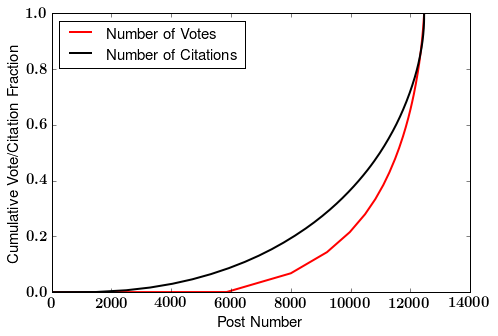

In [18]:
fig, axis = plt.subplots(1, figsize=(7.5, 5))

cv = np.cumsum(sorted(num_votes), dtype='float32')
axis.plot(cv/cv[-1], color='red', label='Number of Votes', linewidth=2)
cc = np.cumsum(sorted(num_cites), dtype='float32')
axis.plot(cc/cc[-1], color='black', label='Number of Citations', linewidth=2)

print stats.ks_2samp(cv/cv[-1], cc/cc[-1])

axis.legend(loc='upper left')

axis.set_xlabel('Post Number')
axis.set_ylabel('Cumulative Vote/Citation Fraction')

plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/cumulativeVoteFraction.jpeg')

In [5]:
position_number = np.array([int(re.search("#([0-9]+)", name).groups(1)[0]) for name in names])
day_of_week = np.array([date.weekday() for date in dates])

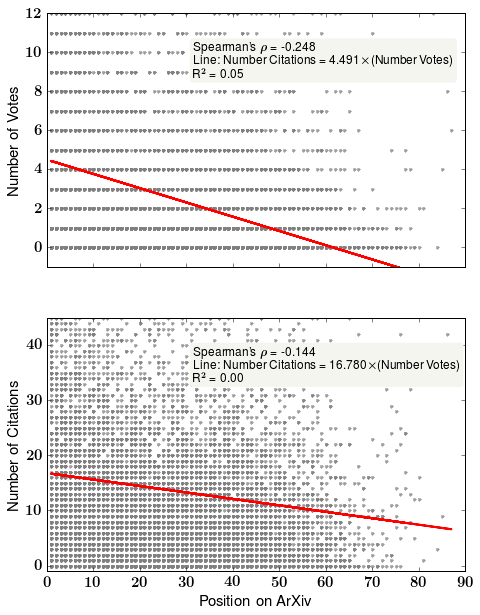

In [16]:
fig, axes = plt.subplots(2, figsize=(7.5, 10))
axis = axes[0]
axis.plot(position_number, num_votes, '.', color='gray', alpha=0.75)
axis.set_xticklabels([])
axis.set_ylabel('Number of Votes')

values = np.empty((len(num_votes), 2))
values[:, 0] = position_number
values[:, 1] = num_votes
Data = pd.DataFrame(values, columns=['X', 'Y'])
model = sm.ols(formula='Y ~ X', data=Data)
fitted = model.fit()
axis.plot(position_number, fitted.fittedvalues, 'r', label="OLS", linewidth=2)
rho, pvalue = stats.spearmanr(position_number, num_votes)

summary_text = r"Spearman's $\rho$ = {:2.3f}".format(rho)
summary_text += "\nLine: " + r"Number Citations = {:2.3f}$\times$(Number Votes)".format(fitted.params[0])
summary_text += "\n" + r"R$^2$ = {:3.2f}".format(fitted.rsquared)

bbox_props = dict(boxstyle="round", fc="#f5f5ef", ec="k", lw=0)
axis.annotate(summary_text, xy=(0.35, 0.75), xycoords='axes fraction', bbox=bbox_props, fontsize=12)


upr_prc = np.percentile(num_votes, 95)
axis.set_ylim([-1, upr_prc])
axis = axes[1]
axis.plot(position_number, num_cites, '.', color='gray', alpha=0.75)
axis.set_ylabel('Number of Citations')
axis.set_xlabel('Position on ArXiv')

values[:, 0] = position_number
values[:, 1] = num_cites
Data = pd.DataFrame(values, columns=['X', 'Y'])
model = sm.ols(formula='Y ~ X', data=Data)
fitted = model.fit()
axis.plot(position_number, fitted.fittedvalues, 'r', label="OLS", linewidth=2)

rho, pvalue = stats.spearmanr(position_number, num_cites)

summary_text = r"Spearman's $\rho$ = {:2.3f}".format(rho)
summary_text += "\nLine: " + r"Number Citations = {:2.3f}$\times$(Number Votes)".format(fitted.params[0])
summary_text += "\n" + r"R$^2$ = {:3.2f}".format(fitted.rsquared)

bbox_props = dict(boxstyle="round", fc="#f5f5ef", ec="k", lw=0)
axis.annotate(summary_text, xy=(0.35, 0.75), xycoords='axes fraction', bbox=bbox_props, fontsize=12)


upr_prc = np.percentile(num_cites, 95)
axis.set_ylim([-1, upr_prc])

plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/position_votes_citations.jpeg')

In [7]:
values = np.empty((len(num_votes), 2))
values[:, 0] = num_votes
values[:, 1] = num_cites
Data = pd.DataFrame(values, columns=['X', 'Y'])
model = sm.ols(formula='Y ~ X', data=Data)
fitted = model.fit()
print fitted.rsquared

0.067051637044


rho = 0.363492, p-value = 0


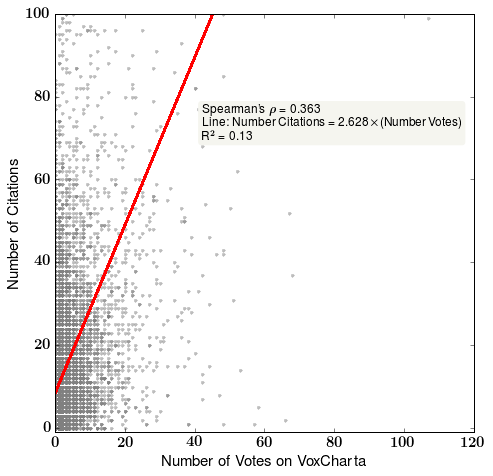

In [17]:
fig, axis= plt.subplots(1, figsize=(7.5, 7.5))
xp = np.linspace(0, 70, 100)
axis.plot(num_votes, num_cites, '.', color='gray', alpha=0.5)
#axis.set_ylim([-1, 10])
axis.set_xlabel('Number of Votes on VoxCharta')
axis.set_ylabel('Number of Citations')
#axis.set_xscale('log')
#axis.set_yscale('log')
axis.set_ylim([-1, 100])
rho, pval = stats.spearmanr(num_votes, num_cites)
print "rho = %g, p-value = %g" % (rho, pval)

values = np.empty((len(num_votes), 2))
values[:, 0] = num_votes
values[:, 1] = num_cites
Data = pd.DataFrame(values, columns=['X', 'Y'])
model = sm.ols(formula='Y ~ X', data=Data)
fitted = model.fit()
axis.plot(num_votes, fitted.fittedvalues, 'r', label="OLS", linewidth=2)
fitted = sm.OLS(num_cites, num_votes).fit()

summary_text = r"Spearman's $\rho$ = {:2.3f}".format(rho)
summary_text += "\nLine: " + r"Number Citations = {:2.3f}$\times$(Number Votes)".format(fitted.params[0])
summary_text += "\n" + r"R$^2$ = {:3.2f}".format(fitted.rsquared)

bbox_props = dict(boxstyle="round", fc="#f5f5ef", ec="k", lw=0)
axis.annotate(summary_text, xy=(0.35, 0.7), xycoords='axes fraction', bbox=bbox_props, fontsize=12)

plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/votes_citations.jpeg')

(0.25740807610692062, 5.5811384205999399e-107)
(0.23963323285956672, 2.8572610696657235e-125)
(0.22760535601389098, 8.2724057645758826e-94)
(0.25942547279771999, 3.8117822872293867e-115)
(0.25060889440297984, 2.8500959586958749e-106)


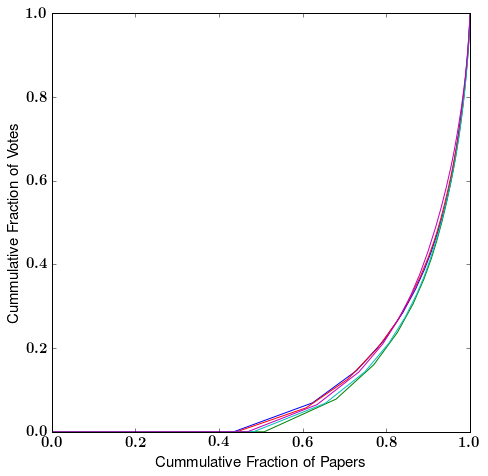

In [9]:
fig, axis = plt.subplots(1, figsize=(7.5, 7.5))

ticklbls = []
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

avgc = np.cumsum(sorted(num_votes), dtype='float32')

for day in xrange(5):
    cv = np.cumsum(sorted(num_votes[day_of_week == day]), dtype='float32')
    axis.plot(np.linspace(0, 1, len(cv)), cv/cv[-1])
    print stats.ks_2samp(avgc, cv)

axis.set_ylabel('Cummulative Fraction of Votes', fontsize=15)
axis.set_xlabel('Cummulative Fraction of Papers', fontsize=15)

#plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/Votes_day.jpeg')

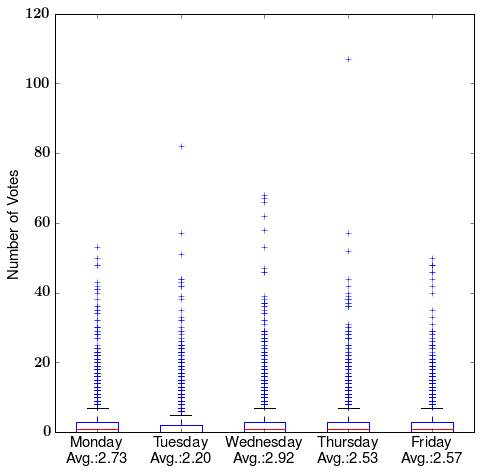

In [10]:
fig, axis = plt.subplots(1, figsize=(7.5, 7.5))

ticklbls = []
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

for day in xrange(5):
    avg = num_votes[day_of_week == day].mean()
    ticklbls.append("{:s}\nAvg.:{:2.2f}".format(days[day], avg))

axis.boxplot([num_votes[day_of_week == day] for day in xrange(5)])
lbsl = axis.set_xticklabels(ticklbls)
axis.set_ylabel('Number of Votes')
plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/Votes_day.jpeg')

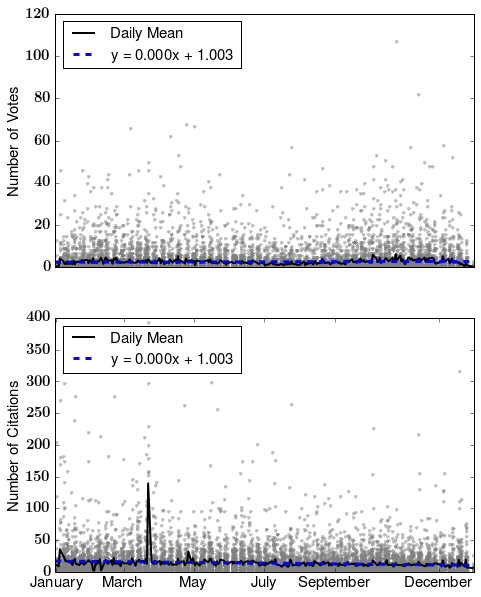

In [13]:
fig, axes = plt.subplots(2, figsize=(7.5, 10))

axis = axes[0]

day_of_year = [date.timetuple().tm_yday for date in dates]
axis.plot(day_of_year, num_votes, '.', color='gray', alpha=0.5)

u = np.unique(day_of_year)
avg_day = [np.mean(num_votes[day_of_year == day]) for day in u]

p = np.poly1d(np.polyfit(u, avg_day, 1))
xp = np.linspace(0, 365, 365)

axis.plot(u, avg_day, 'k', label='Daily Mean', linewidth=2)
_ = axis.plot(xp, p(xp), '--', label='y = {:3.3f}x + {:3.3f}'.format(*xp), linewidth=3)

axis.set_xlim([0, 365])
axis.set_xticks([])
axis.legend(loc='upper left')
axis.set_ylabel('Number of Votes')

axis = axes[1]

day_of_year = [date.timetuple().tm_yday for date in dates]
axis.plot(day_of_year, num_cites, '.', color='gray', alpha=0.5)

u = np.unique(day_of_year)
avg_day = [np.mean(num_cites[day_of_year == day]) for day in u]

p = np.poly1d(np.polyfit(u, avg_day, 1))
xp = np.linspace(0, 365, 365)

axis.plot(u, avg_day, 'k', label='Daily Mean', linewidth=2)
_ = axis.plot(xp, p(xp), '--', label='y = {:3.3f}x + {:3.3f}'.format(*xp), linewidth=3)

axis.set_ylim([0, 400])
axis.set_xlim([0, 365])

axis.set_xticks([datetime(2013, i, 1).timetuple().tm_yday for i in [1, 3, 5, 7, 9, 12]])
axis.set_xticklabels([datetime(2013, i, 1) for i in [1, 3, 5, 7, 9, 12]])
axis.xaxis.set_major_formatter(mpldates.DateFormatter('%B'))

axis.legend(loc='upper left')
axis.set_ylabel('Number of Citations')
plt.savefig('/Users/spardy/Code/Web/Blog/images/voxcharta/Citations_Votes_year.jpeg')